## TaiChung DE PV Forecast with SVR

Data source : TaiChung DE PV plant, CWB WUQI weather.

2016/01/01-2017/12/31.

Time frequcy: 1 hour.

In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Reading the dataset

In [2]:
# quick look data
data = pd.read_csv('data\\Taichung_Power_Sunshine_Irradiance.csv', parse_dates=['Date'], index_col='Date')
print(data.head(12))
print(data.describe())

                     power(KWH)_replaced  SunShine  GloblRad  Solar Irradiance
Date                                                                          
2016-01-01 01:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 02:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 03:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 04:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 05:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 06:00:00                  0.0       0.0      0.00          4.164694
2016-01-01 07:00:00                  0.0       0.0      0.00        107.933226
2016-01-01 08:00:00                146.0       0.7      0.30        305.363132
2016-01-01 09:00:00                444.0       1.0      0.89        477.315428
2016-01-01 10:00:00                680.0       1.0      1.52        621.637047
2016-01-01 11:00:00                892.0       1.0  

power(KWH)_replaced : PV plant 1 hour produce energy ($KWH$). Replace data out of  $Q_{3} + 1.5 \times IQR$   and   $Q_{1} -1.5 \times IQR $.  

Data source :Taichung DE PV plant.

SunShine : Sunshine duration 1 hour . Data source :WUQI CWB.

GlobRad : Solar Irradiance data ($MJ/m^{2}$). Data source :WUQI CWB.

Solar Irradiance : Solar Irradiance data ($KJ/m^{2}$). Data source :Taichung DE PV plant.

# Visualizing data

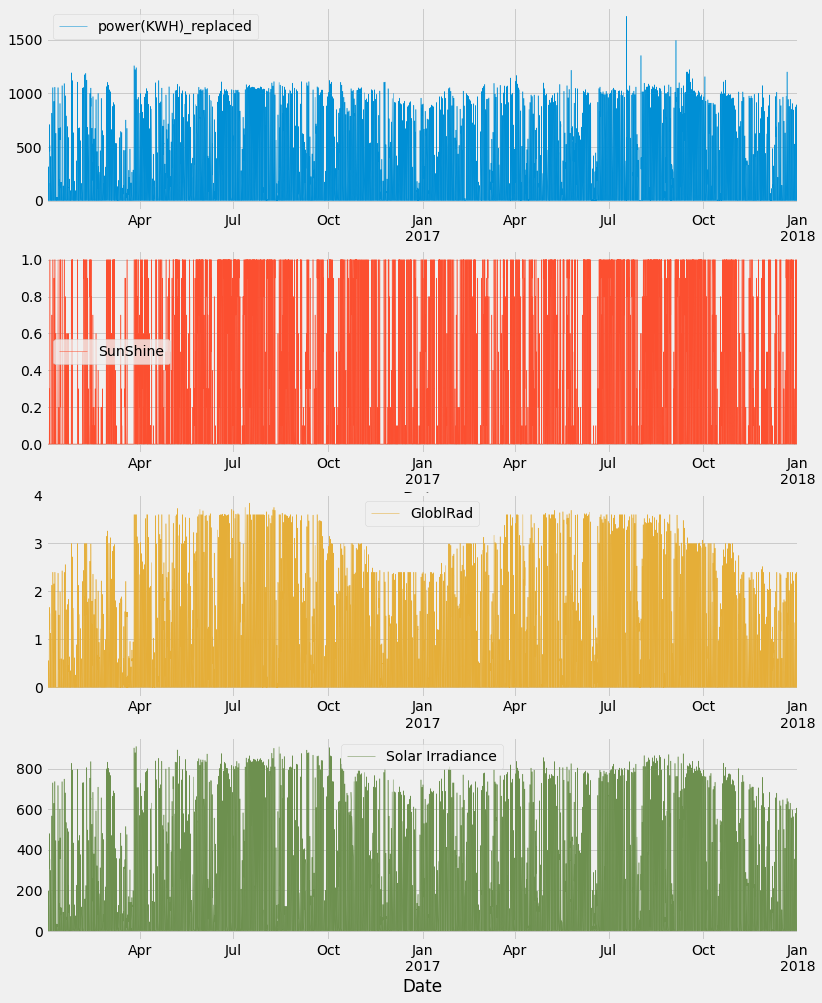

In [3]:
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(4, 1), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

Clearly , contain outlier.

Let data in  $mean - 3 \times std < data < mean + 3 \times std $ .

Don't care night , choose day time .

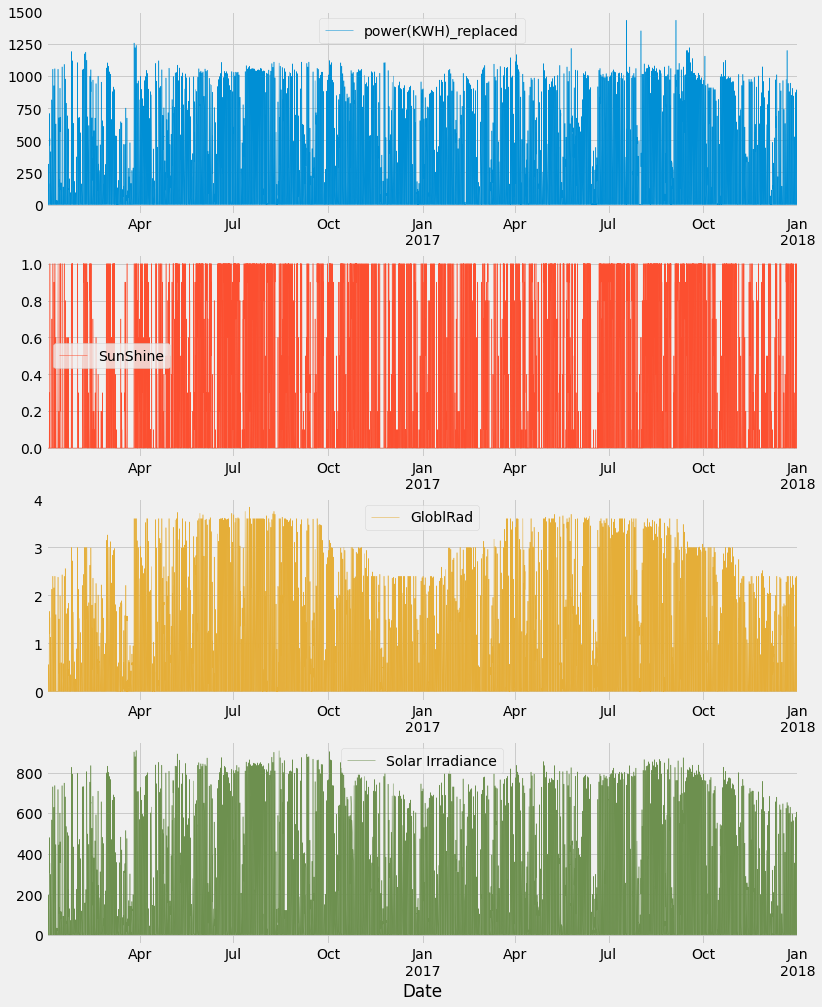

In [4]:
# replace outlier
def replace_outlier(series):
    series_mean = series.mean()
    series_std = series.std()
    upper = series_mean + 3 * series_std 
    lower = series_mean - 3 * series_std
    series_new = np.where(series > upper, upper, np.where(series < lower, lower, series))
    return series_new

# choose day time
daytime_idx = ((6<= data.index.hour) & (data.index.hour<= 18))

for col in data.columns:
    data.loc[daytime_idx,col] = replace_outlier(data.loc[daytime_idx,col])

# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(4, 1), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()


# Feature

According to SARIMA(0,1,0)(0,1,1,24) result: choose lag 1, 24.

In [5]:
# Creating time-lagged features
def create_lags(df, col ,N):
    for i in N:
        df[col+'_Lag_' + str(i)] = df[col].shift(i)
    return df

for col in data.columns:
    data_lag=create_lags(data, col,[1,24])

data_lag.dropna(inplace=True)

Generate hour feature.

In [6]:
data_lag['Hour'] = data_lag.index.hour

Choose target and feature.

In [7]:
# choose day time
daytime_idx = (6<= data_lag.index.hour) & (data_lag.index.hour<= 18)
# choose feature and target
Target = data_lag.loc[daytime_idx, 'power(KWH)_replaced']
Feature = data_lag.loc[daytime_idx,'power(KWH)_replaced_Lag_1':]

Generate morning and afternoon feature.

In [8]:
# One of N encoding.
def morning_afternoon(hour):
    if 6<= hour <=12:
        return 'morning'
    else:
        return 'afternoon'

Feature['period'] = Feature['Hour'].apply(morning_afternoon)
Feature = Feature.join(pd.get_dummies(Feature['period']))
Feature.drop(columns=['period'], inplace=True)
print(Feature.head(1))

                     power(KWH)_replaced_Lag_1  power(KWH)_replaced_Lag_24  \
Date                                                                         
2016-01-02 06:00:00                        0.0                         0.0   

                     SunShine_Lag_1  SunShine_Lag_24  GloblRad_Lag_1  \
Date                                                                   
2016-01-02 06:00:00             0.0              0.0             0.0   

                     GloblRad_Lag_24  Solar Irradiance_Lag_1  \
Date                                                           
2016-01-02 06:00:00              0.0                     0.0   

                     Solar Irradiance_Lag_24  Hour  afternoon  morning  
Date                                                                    
2016-01-02 06:00:00                 4.164694     6          0        1  


Choose 16% data (last 4 month) to validation.

In [9]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(Feature, Target, test_size=0.166,shuffle=False)

# Tune Parameters

SVR 

$$\underset {b,w,\epsilon}{min} \frac{1}{2}w^{T}{w} +C \sum^{N}_{n=1} \epsilon_{n}$$

s.t. $$y_{n} - w^{T}x_{n} - b < \epsilon_{n}$$
$$\epsilon_{n} \geq 0 $$

C(cost) is not easy to optimizer, so eave one out validation.

Time seriese can't cross validation.

You can't use furture to predict past.


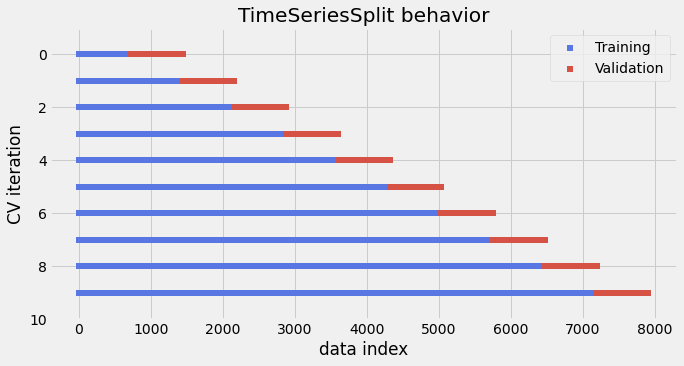

In [10]:
cv = TimeSeriesSplit(n_splits=10)
fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr, tt) in enumerate(cv.split(X_train, y_train)):
# Plot training and validation indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10,-1],title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training','Validation'])



Choose C = 500, 1000, 1500, 2000 .

Mean squared error is score.

In [11]:
# Grab the date of the first index of each validation set
cv_index = [X_train.index[tt[0]] for tr, tt in cv.split(X_train, y_train)]
val_score = pd.DataFrame()

def score_fcn(est, X, y):
    """Return MSE between model predictions and a validation set."""
    y_predict = est.predict(X)
    MSE = mean_squared_error(y, y_predict)
    return MSE

for i in [500, 1000, 1500, 2000]:
    regression_model_rbf = SVR(kernel='rbf', C=i)
    cv_scores = cross_val_score(regression_model_rbf, X_train, y_train, cv=cv, scoring=score_fcn)
    cv_scores = pd.Series(cv_scores, index=cv_index)
    val_score['Cost='+str(i)] = cv_scores

visualizing result.

[Text(0.5, 1.0, 'Validation data')]

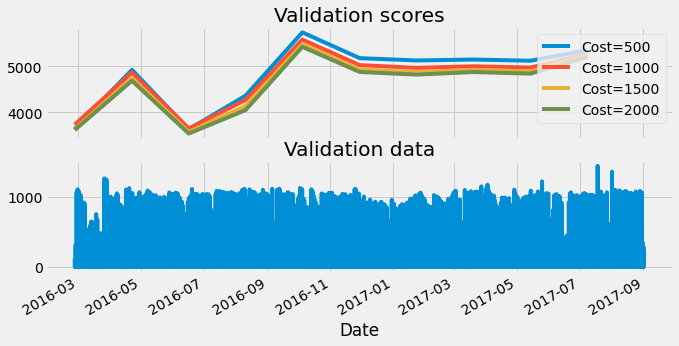

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# Calculate a rolling mean of scores over time
val_score_mean = val_score.rolling(10, min_periods=1).mean()
val_score_mean.plot(ax=axs[0])
axs[0].set(title='Validation scores')
# Plot the raw data
y_train[cv_index[0]:].plot(ax=axs[1])
axs[1].set(title='Validation data')


# Validation Model

Choose cost = 1000.

Train last 10% train data. 

Predict.

In [13]:
regression_model = SVR(kernel='rbf', C=1000)
regression_model.fit(X_train, y_train)
y_predict = regression_model.predict(X_test)

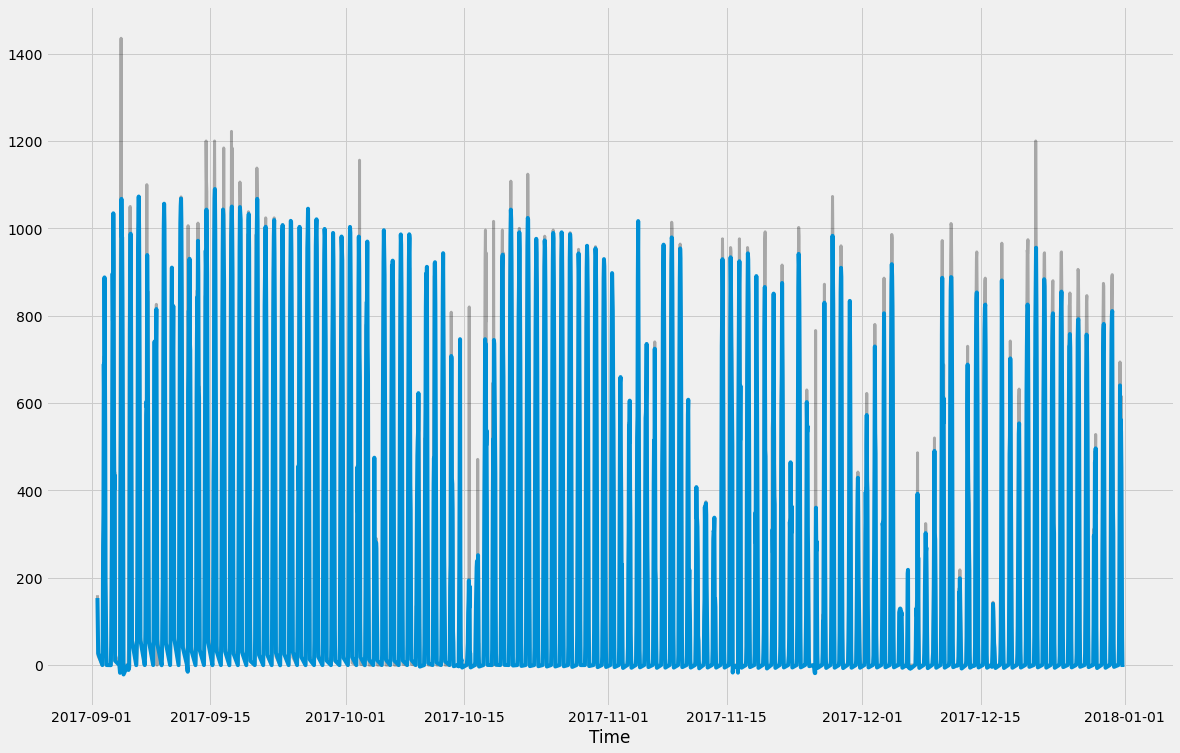

In [14]:
# visualizing predict
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(y_test, color='k', alpha=.3, lw=3)
ax.plot(y_test.index, y_predict)
ax.set(xlabel="Time")
plt.show()


Model Score 

predict value : $ \hat{y}$  

actual value : $y$  

max of y : $y_{max}$

Mean squared error :

$$ \frac{1}{n} \sum_{k=1}^n ({y_{k} -\hat{y_{k}}})^2 $$

Mean absoluate error :

$$ \frac{1}{n} \sum_{k=1}^n \vert {y_{k} -\hat{y_{k}}} \vert $$

Mean relative error :

$$ \frac{100\%}{n} \sum_{k=1}^n \frac{{y_{k} -\hat{y_{k}}}}{y_{max}}  $$

Coefficient of determination :

$$ R^{2} \equiv 1 - \frac {SS_{res}}{SS_{tot}}$$

$$SS_{res} = \sum_{k=1}^n  { (\hat{y_{k}} - \tilde {y})^2}   ,SS_{tot} = \sum_{k=1}^n  { ({y_{k}} - \tilde {y})^2} 
, \tilde {y} = \frac{1}{n} \sum_{k=1}^n {y_{k}} $$

<!-- Mean absoluate percentage error :

% $$ \frac{100\%}{n} \sum_{k=1}^n \vert \frac{{y_{k} -\hat{y_{k}}}}{y_{k}} \vert $$ -->

In [15]:
def MRE(x,y):
    return np.nanmean(np.abs((x-y)/np.max(x)))

print('Mean squared error:{:.4f}'.format(mean_squared_error(y_test,y_predict)))
print('Mean absolute error:{:.4f}'.format(mean_absolute_error(y_test,y_predict)))
print('Mean relative error:{:.2%}'.format(MRE(y_test,y_predict)))
print('Coefficient of determination:{:.4f}'.format(r2_score(y_test,y_predict)))

Mean squared error:8274.9620
Mean absolute error:41.8690
Mean relative error:2.92%
Coefficient of determination:0.9334


# Look at Worst and Best Predicted Days

In [16]:
test_days = pd.DataFrame(y_test)
test_days['Predicted'] = y_predict 
test_days['error'] = test_days['power(KWH)_replaced'] - test_days['Predicted']
test_days['abs_error'] = test_days['error'].apply(np.abs)
test_days['year']=test_days.index.year
test_days['month']=test_days.index.month
test_days['day']=test_days.index.day

error_by_day = test_days.groupby(['year','month','day']).mean()[['power(KWH)_replaced','Predicted','error','abs_error']]

Looking worst predicted ten days.

In [17]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

power(KWH)_replaced   Predicted       error   abs_error
year month day                                                         
2017 11    18            154.307692  332.982825 -178.675133  180.255274
     9     7             378.384615  416.376293  -37.991677  158.489530
           5             518.615385  373.889445  144.725939  154.904034
           4             616.630936  505.412725  111.218211  149.127357
     11    19            406.923077  265.250621  141.672456  148.852612
     10    11            384.307692  412.874124  -28.566431  148.608023
           18            355.076923  368.768951  -13.692028  148.294500
     11    20            347.538462  267.736494   79.801968  142.323201
     10    2             407.307692  454.589517  -47.281824  130.291198
           17            449.461538  373.070402   76.391137  118.957420

Looking best predicted ten days.

In [18]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

power(KWH)_replaced   Predicted     error  abs_error
year month day                                                      
2017 10    24            489.153846  488.068451  1.085395   4.374222
     11    13            144.615385  145.899879 -1.284495   4.561565
     10    23            495.538462  494.608846  0.929616   4.716159
           25            508.153846  509.347276 -1.193430   4.808918
     11    9             467.307692  466.526470  0.781222   4.939894
     12    16             42.000000   40.426900  1.573100   5.098221
     11    11            157.000000  160.321531 -3.321531   5.718191
     9     1              92.333333   89.730806  2.602527   6.378185
     12    12             72.461538   67.323526  5.138013   6.743563
     11    30            169.846154  166.217631  3.628523   6.861724

# Plotting  best/worst predicted days

Plotting worst predicted day.

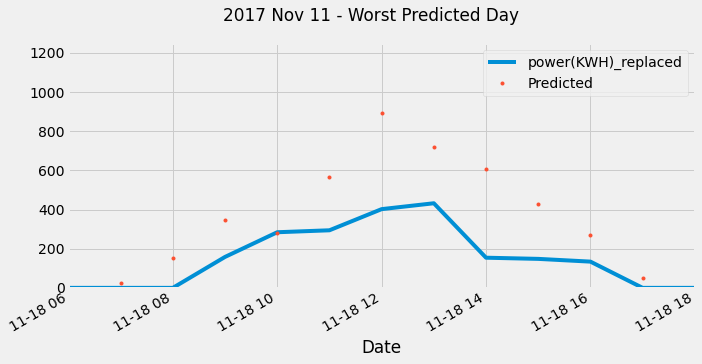

In [19]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = test_days[['power(KWH)_replaced','Predicted']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 1250)
ax.set_xbound(lower='2017-11-18 06:00', upper='2017-11-18 18:00')
plot = plt.suptitle('2017 Nov 18 - Worst Predicted Day')

Plotting best predicted day.

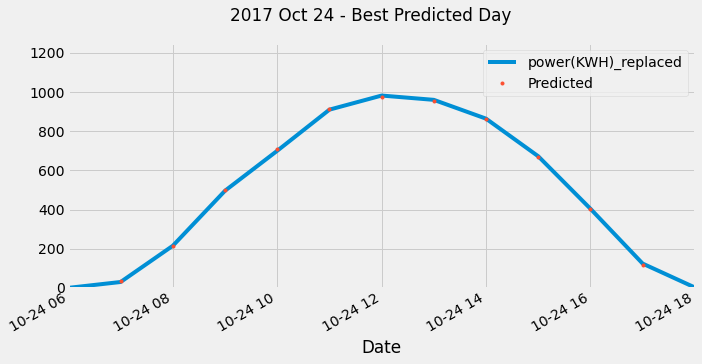

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = test_days[['power(KWH)_replaced','Predicted']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 1250)
ax.set_xbound(lower='2017-10-24 06:00', upper='2017-10-24 18:00')
plot = plt.suptitle('2017 Oct 24 - Best Predicted Day')